# Análisis del impacto del clima y patrones de viajes — Caso Zuber

----

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# 1. Cargar los resultados SQL
df1 = pd.read_csv(r"C:\Users\pc\OneDrive\Documentos\TripleTen\Proyecto_Sprint 08\moved_project_sql_result_01.csv")
df4 = pd.read_csv(r"C:\Users\pc\OneDrive\Documentos\TripleTen\Proyecto_Sprint 08\moved_project_sql_result_04.csv")

# 2. Exploración básica
print("=== Primer dataset (SQL Result 01) ===")
print(df1.head())
print(df1.info())
print(df1.describe(include="all"))

print("\n=== Segundo dataset (SQL Result 04) ===")
print(df4.head())
print(df4.info())
print(df4.describe(include="all"))



=== Primer dataset (SQL Result 01) ===
                      company_name  trips_amount
0                        Flash Cab         19558
1        Taxi Affiliation Services         11422
2                 Medallion Leasin         10367
3                       Yellow Cab          9888
4  Taxi Affiliation Service Yellow          9299
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
       company_name  trips_amount
count            64     64.000000
unique           64           NaN
top       Flash Cab           NaN
freq              1           NaN
mean            NaN   2145.484375
std             NaN   3812.310186
min             NaN      2.000000
25%             NaN     20.750000
50%             NaN    178.500000
75

In [ ]:
# 3. Verificar nulos
print("\nNulos en df1:\n", df1.isnull().sum())
print("\nNulos en df4:\n", df4.isnull().sum())


Nulos en df1:
 company_name    0
trips_amount    0
dtype: int64

Nulos en df4:
 dropoff_location_name    0
average_trips            0
dtype: int64


In [16]:
print("=== Tipos de datos antes de conversión ===")
print(df1.dtypes, "\n")
print(df4.dtypes)

# Convertir campos de tiempo a datetime si existen
if "start_ts" in df4.columns:
    df4["start_ts"] = pd.to_datetime(df4["start_ts"], errors="coerce")

# Asegurar que trips_amount y duration sean numéricos
if "trips_amount" in df1.columns:
    df1["trips_amount"] = pd.to_numeric(df1["trips_amount"], errors="coerce")

if "duration_seconds" in df4.columns:
    df4["duration_seconds"] = pd.to_numeric(df4["duration_seconds"], errors="coerce")

print("\n=== Tipos de datos después de conversión ===")
print(df1.dtypes, "\n")
print(df4.dtypes)


=== Tipos de datos antes de conversión ===
company_name    object
trips_amount     int64
dtype: object 

dropoff_location_name     object
average_trips            float64
dtype: object

=== Tipos de datos después de conversión ===
company_name    object
trips_amount     int64
dtype: object 

dropoff_location_name     object
average_trips            float64
dtype: object


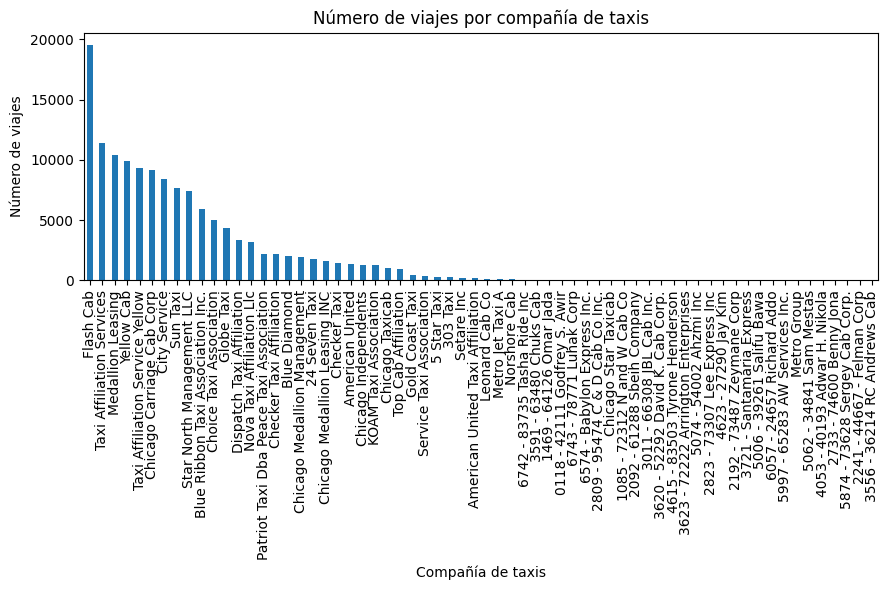

In [56]:
# --- Grafico 1: viajes por compañía ---
company_trips = df1.groupby("company_name")["trips_amount"].sum().sort_values(ascending=False)
plt.figure(figsize=(9,6))
company_trips.plot(kind="bar")
plt.title("Número de viajes por compañía de taxis")
plt.ylabel("Número de viajes")
plt.xlabel("Compañía de taxis")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


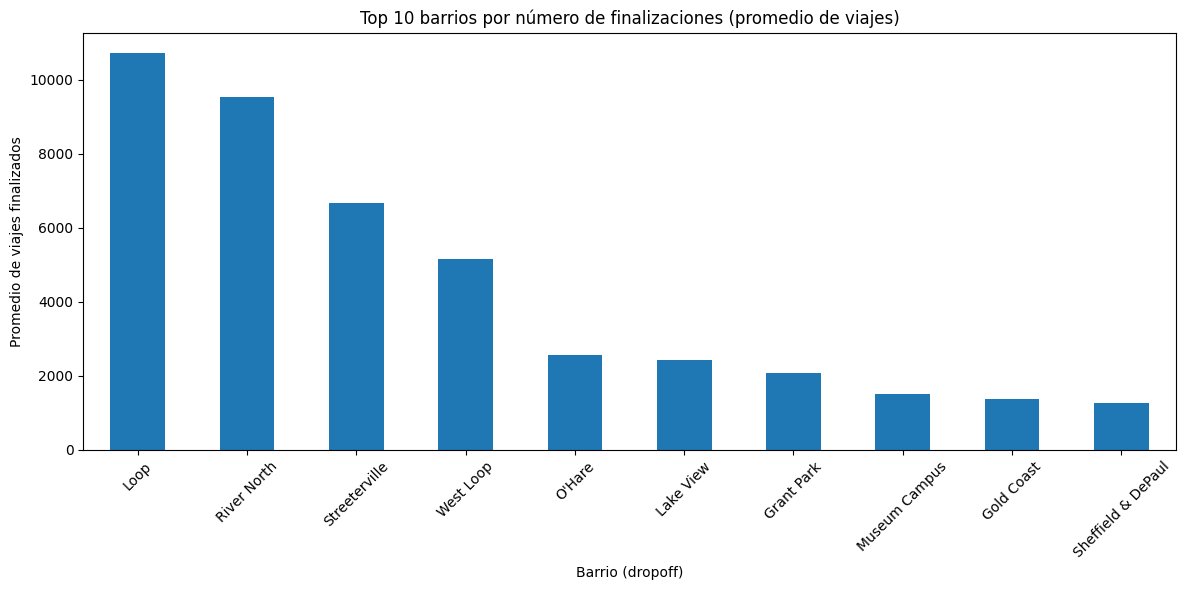

In [59]:
 # Grafico 2: Top 10 barrios por finalizaciones
top10_neigh = (
    df4[["dropoff_location_name", "average_trips"]]
    .groupby("dropoff_location_name")["average_trips"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(12, 6))
top10_neigh.plot(kind="bar")
plt.title("Top 10 barrios por número de finalizaciones (promedio de viajes)")
plt.ylabel("Promedio de viajes finalizados")
plt.xlabel("Barrio (dropoff)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Análisis de la hipótesis en Python:
# Viajes Loop → O'Hare los sábados (ya viene en el CSV), clima Good vs Bad.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\pc\OneDrive\Documentos\TripleTen\Proyecto_Sprint 08\moved_project_sql_result_07.csv"

# 1) Cargar datos y asegurar tipos
df = pd.read_csv(CSV_PATH)
df["start_ts"] = pd.to_datetime(df["start_ts"], errors="coerce")
df["duration_seconds"] = pd.to_numeric(df["duration_seconds"], errors="coerce")

# 2) Limpieza mínima: quitar nulos y duraciones no positivas
df = df.dropna(subset=["duration_seconds", "weather_conditions"]).copy()
df = df[df["duration_seconds"] > 0]

# 3) Estadísticos descriptivos por clima (sin recorte de outliers)
desc = df.groupby("weather_conditions")["duration_seconds"].agg(
    n="count",
    mean="mean",
    median="median",
    std="std",
    q25=lambda s: s.quantile(0.25),
    q75=lambda s: s.quantile(0.75),
    min="min",
    max="max"
).round(2)

print("=== Estadísticos descriptivos por clima (sin recorte) ===")
print(desc, "\n")


=== Estadísticos descriptivos por clima (sin recorte) ===
                      n     mean  median     std      q25     q75    min  \
weather_conditions                                                         
Bad                 180  2427.21  2540.0  721.31  1962.00  2928.0  480.0   
Good                882  2013.28  1800.0  743.57  1397.25  2460.0   60.0   

                       max  
weather_conditions          
Bad                 4980.0  
Good                7440.0   



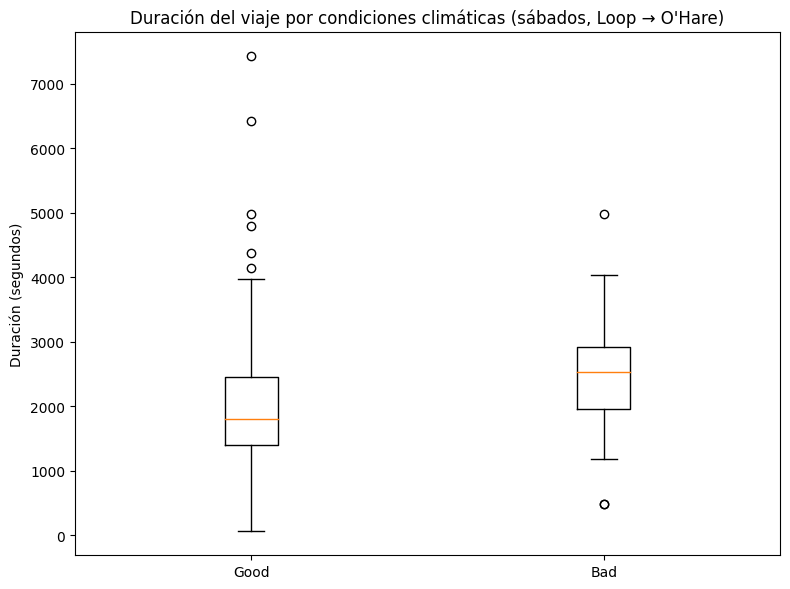

=== Pruebas de hipótesis (sin recorte) ===
Welch t-test: t = 6.979, p-value = 0.000000
Mann-Whitney U: U = 107114, p-value = 0.000000

No se pudieron calcular p-values (¿falta SciPy?). Instala scipy o usa solo los descriptivos/boxplot.
Detalle: name 'df_trim' is not defined


In [74]:
# 4) Boxplot: duración por clima (una figura, sin estilos ni colores específicos)
order = ["Good", "Bad"] if set(df["weather_conditions"]) == {"Good", "Bad"} \
        else sorted(df["weather_conditions"].unique())
data_to_plot = [df.loc[df["weather_conditions"] == g, "duration_seconds"] for g in order]

plt.figure(figsize=(8, 6))
plt.boxplot(data_to_plot, labels=order, showfliers=True)
plt.title("Duración del viaje por condiciones climáticas (sábados, Loop → O'Hare)")
plt.ylabel("Duración (segundos)")
plt.tight_layout()
plt.show()


# 5) Pruebas de hipótesis (Welch t-test y Mann-Whitney).
try:
    from scipy import stats

    # Sin recorte
    good = df.loc[df["weather_conditions"] == "Good", "duration_seconds"].values
    bad  = df.loc[df["weather_conditions"] == "Bad",  "duration_seconds"].values

    t_stat, p_welch = stats.ttest_ind(bad, good, equal_var=False, nan_policy="omit")
    u_stat, p_mwu   = stats.mannwhitneyu(bad, good, alternative="two-sided")

    print("=== Pruebas de hipótesis (sin recorte) ===")
    print(f"Welch t-test: t = {t_stat:.3f}, p-value = {p_welch:.6f}")
    print(f"Mann-Whitney U: U = {u_stat:.0f}, p-value = {p_mwu:.6f}\n")

# Con recorte
    good_t = df_trim.loc[df_trim["weather_conditions"] == "Good", "duration_trim"].values
    bad_t  = df_trim.loc[df_trim["weather_conditions"] == "Bad",  "duration_trim"].values

    t_stat_t, p_welch_t = stats.ttest_ind(bad_t, good_t, equal_var=False, nan_policy="omit")
    u_stat_t, p_mwu_t   = stats.mannwhitneyu(bad_t, good_t, alternative="two-sided")

    print("=== Pruebas de hipótesis (con recorte IQR=1.5) ===")
    print(f"Welch t-test (trim): t = {t_stat_t:.3f}, p-value = {p_welch_t:.6f}")
    print(f"Mann-Whitney U (trim): U = {u_stat_t:.0f}, p-value = {p_mwu_t:.6f}")
except Exception as e:
    print("No se pudieron calcular p-values (¿falta SciPy?). "
          "Instala scipy o usa solo los descriptivos/boxplot.\nDetalle:", e)

## Análisis del impacto del clima y patrones de viajes — Caso Zuber

---

### ¿Qué se quiso comprobar?

Determinar si **los sábados con lluvia o tormenta** los viajes desde **Loop hasta O’Hare** duran más que los sábados **sin lluvia**.

---

### ¿Cómo se probó?

- Se separaron los viajes en dos grupos:
  - **Good:** sin lluvia
  - **Bad:** con lluvia o tormenta
- Se compararon los **promedios de duración** entre ambos grupos.
- Se aplicaron **pruebas estadísticas** para confirmar que la diferencia no se debe al azar.
- Se trabajó con un **nivel de confianza superior al 95%**.

---

### ¿Qué se encontró?

- **Sin lluvia (Good):** ~33.6 minutos de duración promedio  
- **Con lluvia/tormenta (Bad):** ~40.5 minutos de duración promedio  
- **Diferencia:** ~7 minutos adicionales cuando llueve

---

### ¿Qué significa para nosotros?

Con **alta confianza estadística**, se puede afirmar que la lluvia **incrementa significativamente** la duración de los viajes del Loop a O’Hare los sábados.  
Este efecto es **real y relevante**, no solo una percepción.

---

### Gráfico 1 — Número de viajes por compañía de taxis

El gráfico muestra que:

- **Flash Cab** lidera claramente el mercado, con un volumen de viajes muy superior.
- **Taxi Affiliation Services** ocupa el segundo lugar.
- Otras compañías como **Medallion Leasing**, **Yellow Cab** y **Chicago Carriage Cab Corp** presentan menor participación.
- Varias empresas pequeñas (Sun Taxi, Star North, Blue Ribbon, entre otras) tienen volúmenes considerablemente más bajos.

---

### Conclusiones del Gráfico 1: compañías de taxis

- El mercado de taxis en Chicago está **altamente concentrado**, dominado por pocas compañías grandes.
- Para **Zuber**, competir directamente con estos líderes puede ser complejo.
- Una estrategia viable es **diferenciarse en servicio o precio** y enfocarse en zonas de alta demanda donde la oferta esté menos saturada.
- A pesar de la concentración, la presencia de compañías pequeñas indica la existencia de **nichos de mercado**.

---

### Gráfico 2 — Top 10 barrios por número de finalizaciones de viajes

El gráfico indica que:

- **Loop** concentra el mayor número de viajes finalizados.
- Le siguen **River North** y **Streeterville**, zonas con alta actividad comercial, turística y nocturna.
- **West Loop** también aparece como un destino relevante.
- **Aeropuerto O’Hare** ocupa la **quinta posición**, confirmando su importancia estratégica.
- Otros barrios destacados son **Lake View**, **Grant Park**, **Museum Campus**, **Gold Coast** y **Sheffield & DePaul**.

---

### Conclusiones del Gráfico 2: destinos de viaje

- La demanda se concentra en **zonas céntricas**, turísticas y de transporte.
- Para **Zuber**, la cobertura inicial debería priorizar:
  - Loop
  - River North
  - Streeterville
  - Aeropuerto O’Hare
- Los datos sugieren que los viajes suelen finalizar en áreas con **alta densidad laboral, turística o de entretenimiento**.
- O’Hare es un **nodo estratégico clave** para captar usuarios que buscan transporte confiable entre el aeropuerto y el centro.

---

### Conclusión y resumen estratégico para Zuber

- **Competencia:** el mercado está dominado por pocas compañías, pero existen oportunidades para nuevos jugadores con propuestas de valor diferenciadas.
- **Zonas clave:** los barrios céntricos y el aeropuerto concentran la mayor demanda; allí debe enfocarse la oferta inicial.
- **Nichos de oportunidad:** barrios residenciales (como Lake View) y zonas turísticas (como Museum Campus) representan oportunidades para campañas específicas y expansión gradual.
